原文代码作者：François Chollet

github：https://github.com/fchollet/deep-learning-with-python-notebooks

中文注释制作：黄海广

github：https://github.com/fengdu78

代码全部测试通过。

配置环境：keras 2.2.1（原文是2.0.8，运行结果一致），tensorflow 1.8，python 3.6，

主机：显卡：一块1080ti；内存：32g（注：绝大部分代码不需要GPU）
![公众号](data/gongzhong.jpg)

In [1]:
import keras
keras.__version__

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'2.2.4'

# 5.2 - Using convnets with small datasets
# 在小型数据集上使用卷积神经网络

This notebook contains the code sample found in Chapter 5, Section 2 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

## Training a convnet from scratch on a small dataset

Having to train an image classification model using only very little data is a common situation, which you likely encounter yourself in 
practice if you ever do computer vision in a professional context.

Having "few" samples can mean anywhere from a few hundreds to a few tens of thousands of images. As a practical example, we will focus on 
classifying images as "dogs" or "cats", in a dataset containing 4000 pictures of cats and dogs (2000 cats, 2000 dogs). We will use 2000 
pictures for training, 1000 for validation, and finally 1000 for testing.

In this section, we will review one basic strategy to tackle this problem: training a new model from scratch on what little data we have. We 
will start by naively training a small convnet on our 2000 training samples, without any regularization, to set a baseline for what can be 
achieved. This will get us to a classification accuracy of 71%. At that point, our main issue will be overfitting. Then we will introduce 
*data augmentation*, a powerful technique for mitigating overfitting in computer vision. By leveraging data augmentation, we will improve 
our network to reach an accuracy of 82%.

In the next section, we will review two more essential techniques for applying deep learning to small datasets: *doing feature extraction 
with a pre-trained network* (this will get us to an accuracy of 90% to 93%), and *fine-tuning a pre-trained network* (this will get us to 
our final accuracy of 95%). Together, these three strategies -- training a small model from scratch, doing feature extracting using a 
pre-trained model, and fine-tuning a pre-trained model -- will constitute your future toolbox for tackling the problem of doing computer 
vision with small datasets.

## 在小型数据集上从头开始训练一个卷积神经网络
使用很少的数据来训练一个图像分类模型，这是很常见的情况，如果你要从事计算机视觉方面的职业，很可能会在实践中遇到这种情况。“很少的”样本可能是几百张图像，也可能是几万张图像。来看一个实例，我们将重点讨论猫狗图像分类，数据集中包含 4000 张猫和狗的图像（2000 张猫的图像，2000 张狗的图像）。我们将 2000 张图像用于训练，1000 张用于验证，1000张用于测试。本节将介绍解决这一问题的基本策略，即使用已有的少量数据从头开始训练一个新模型。

首先，在 2000 个训练样本上训练一个简单的小型卷积神经网络，不做任何正则化，为模型目标设定一个基准。这会得到 71% 的分类精度。此时主要的问题在于过拟合。然后，我们会介绍数据增强（data augmentation），它在计算机视觉领域是一种非常强大的降低过拟合的技术。使用数据增强之后，网络精度将提高到 82%。

下一节会介绍将深度学习应用于小型数据集的另外两个重要技巧：用预训练的网络做特征提 取（得到的精度范围在 90%~93%），对预训练的网络进行微调（最终精度为 95%）。总而言之，这三种策略——从头开始训练一个小型模型、使用预训练的网络做特征提取、对预训练的网络进行微调——构成了你的工具箱，未来可用于解决小型数据集的图像分类问题。


## The relevance of deep learning for small-data problems

You will sometimes hear that deep learning only works when lots of data is available. This is in part a valid point: one fundamental 
characteristic of deep learning is that it is able to find interesting features in the training data on its own, without any need for manual 
feature engineering, and this can only be achieved when lots of training examples are available. This is especially true for problems where 
the input samples are very high-dimensional, like images.

However, what constitutes "lots" of samples is relative -- relative to the size and depth of the network you are trying to train, for 
starters. It isn't possible to train a convnet to solve a complex problem with just a few tens of samples, but a few hundreds can 
potentially suffice if the model is small and well-regularized and if the task is simple. 
Because convnets learn local, translation-invariant features, they are very 
data-efficient on perceptual problems. Training a convnet from scratch on a very small image dataset will still yield reasonable results 
despite a relative lack of data, without the need for any custom feature engineering. You will see this in action in this section.

But what's more, deep learning models are by nature highly repurposable: you can take, say, an image classification or speech-to-text model 
trained on a large-scale dataset then reuse it on a significantly different problem with only minor changes. Specifically, in the case of 
computer vision, many pre-trained models (usually trained on the ImageNet dataset) are now publicly available for download and can be used 
to bootstrap powerful vision models out of very little data. That's what we will do in the next section.

For now, let's get started by getting our hands on the data.
## 深度学习与小数据问题的相关性

有时你会听人说，仅在有大量数据可用时，深度学习才有效。这种说法部分正确：深度学习的一个基本特性就是能够独立地在训练数据中找到有趣的特征，无须人为的特征工程，而这只在拥有大量训练样本时才能实现。对于输入样本的维度非常高（比如图像）的问题尤其如此。

但对于初学者来说，所谓“大量”样本是相对的，即相对于你所要训练网络的大小和深度而言。只用几十个样本训练卷积神经网络就解决一个复杂问题是不可能的，但如果模型很小， 并做了很好的正则化，同时任务非常简单，那么几百个样本可能就足够了。由于卷积神经网络 学到的是局部的、平移不变的特征，它对于感知问题可以高效地利用数据。虽然数据相对较少，但在非常小的图像数据集上从头开始训练一个卷积神经网络，仍然可以得到不错的结果，而且无须任何自定义的特征工程。本节你将看到其效果。

此外，深度学习模型本质上具有高度的可复用性，比如，已有一个在大规模数据集上训练的图像分类模型或语音转文本模型，你只需做很小的修改就能将其复用于完全不同的问题。特 别是在计算机视觉领域，许多预训练的模型（通常都是在 ImageNet 数据集上训练得到的）现在都可以公开下载，并可以用于在数据很少的情况下构建强大的视觉模型。这是下一节的内容。 

我们先来看一下数据。


## Downloading the data

The cats vs. dogs dataset that we will use isn't packaged with Keras. It was made available by Kaggle.com as part of a computer vision 
competition in late 2013, back when convnets weren't quite mainstream. You can download the original dataset at: 
`https://www.kaggle.com/c/dogs-vs-cats/data` (you will need to create a Kaggle account if you don't already have one -- don't worry, the 
process is painless).

The pictures are medium-resolution color JPEGs. They look like this:

## 下载数据

本节用到的猫狗分类数据集不包含在 Keras 中。它由 Kaggle 在 2013 年末公开并作为一项 计算视觉竞赛的一部分，当时卷积神经网络还不是主流算法。你可以从 https://www.kaggle.com/c/dogs-vs-cats/data 下载原始数据集（如果没有 Kaggle 账号的话，你需要注册一个，别担心，很简单）。

这些图像都是中等分辨率的彩色 JPEG 图像。下图给出了一些样本示例。


![cats_vs_dogs_samples](data/cats_vs_dogs_samples.jpg)

Unsurprisingly, the cats vs. dogs Kaggle competition in 2013 was won by entrants who used convnets. The best entries could achieve up to 
95% accuracy. In our own example, we will get fairly close to this accuracy (in the next section), even though we will be training our 
models on less than 10% of the data that was available to the competitors.
This original dataset contains 25,000 images of dogs and cats (12,500 from each class) and is 543MB large (compressed). After downloading 
and uncompressing it, we will create a new dataset containing three subsets: a training set with 1000 samples of each class, a validation 
set with 500 samples of each class, and finally a test set with 500 samples of each class.

Here are a few lines of code to do this:

不出所料，2013 年的猫狗分类 Kaggle 竞赛的优胜者使用的是卷积神经网络。最佳结果达到了 95% 的精度。本例中，虽然你只在不到参赛选手所用的 10% 的数据上训练模型，但结果也和这个精度相当接近（见下一节）。

这个数据集包含 25 000 张猫狗图像（每个类别都有 12 500 张），大小为 543MB（压缩后）。 下载数据并解压之后，你需要创建一个新数据集，其中包含三个子集：每个类别各 1000 个样本 的训练集、每个类别各 500 个样本的验证集和每个类别各 500 个样本的测试集。

创建新数据集的代码如下所示。

备注：数据已经下载好了，放在data/kaggle_original_data目录


In [2]:
import os, shutil

下面的代码有修改，做了判断是否目录已经存在

In [3]:
def make_dir(root, dir_name):
    '''
    在 root 下生成目录
    '''
    _dir = root + dir_name + "/"  # 拼出分完整目录名
    if not os.path.exists(_dir):  # 是否存在目录，如果没有创建
        os.makedirs(_dir)
    return _dir

In [4]:
# The path to the directory where the original
# dataset was uncompressed（原始数据集解压目录的路径）
root = 'data/'
original_dataset_dir = f'{root}kaggle_original_data'

# The directory where we will
# store our smaller dataset（保存较小数据集的目录）
base_dir_name = 'cats_and_dogs_small'
base_dir = make_dir(root, base_dir_name)

# Directories for our training, validation and test splits
#（分别对应划分后的训练、 验证和测试的目录）
train_dir = make_dir(base_dir, 'train')

# Directory with our training cat pictures(猫的训练图像目录)
train_cats_dir = make_dir(train_dir, 'cats')

# Directory with our training dog pictures(狗的训练图像目录)
train_dogs_dir = make_dir(train_dir, 'dogs')

validation_dir = make_dir(base_dir, 'validation')

# Directory with our validation cat pictures(猫的验证图像目录)
validation_cats_dir = make_dir(validation_dir, 'cats')

# Directory with our validation dog pictures(狗的验证图像目录)
validation_dogs_dir = make_dir(validation_dir, 'dogs')

test_dir = make_dir(base_dir, 'test')

# Directory with our test cat pictures（猫的测试图像目录）
test_cats_dir = make_dir(test_dir, 'cats')

# Directory with our test dog pictures（狗的测试图像目录）
test_dogs_dir = make_dir(test_dir, 'dogs')

In [5]:
def copyfile(original_dir, obj_dir, fnames):
    '''
    将 original_dir 目录下的 fnames 复制到 obj_dir
    '''
    for fname in fnames:
        src = os.path.join(original_dir, fname)
        dst = os.path.join(obj_dir, fname)
        shutil.copyfile(src, dst)    

In [6]:
# Copy first 1000 cat images to train_cats_dir（将前 1000 张猫的图像复制 到 train_cats_dir）
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
copyfile(original_dataset_dir, train_cats_dir, fnames)

# Copy next 500 cat images to validation_cats_dir（将 接 下 来 500 张 猫 的 图像 复 制到 validation_cats_dir）
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
copyfile(original_dataset_dir, validation_cats_dir, fnames)
    
# Copy next 500 cat images to test_cats_dir（将 接 下 来的 500 张 猫 的 图像 复制到 test_cats_dir）
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
copyfile(original_dataset_dir, test_cats_dir, fnames)
    
# Copy first 1000 dog images to train_dogs_dir（将前 1000 张狗的图像复制 到 train_dogs_dir）
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
copyfile(original_dataset_dir, train_dogs_dir, fnames)
    
# Copy next 500 dog images to validation_dogs_dir（将接下来 500 张狗的图像复 制到 validation_dogs_dir）
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
copyfile(original_dataset_dir, validation_dogs_dir, fnames)
    
# Copy next 500 dog images to test_dogs_dir（将接下来 500 张狗的图像复制到 test_dogs_dir）
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
copyfile(original_dataset_dir, test_dogs_dir, fnames)

As a sanity check, let's count how many pictures we have in each training split (train/validation/test):

我们来检查一下，看看每个分组（训练 / 验证 / 测试）中分别包含多少张图像。

In [7]:
print('total training cat images:', len(os.listdir(train_cats_dir)))

print('total training dog images:', len(os.listdir(train_dogs_dir)))

print('total validation cat images:', len(os.listdir(validation_cats_dir)))

print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

print('total test cat images:', len(os.listdir(test_cats_dir)))

print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500



So we have indeed 2000 training images, and then 1000 validation images and 1000 test images. In each split, there is the same number of 
samples from each class: this is a balanced binary classification problem, which means that classification accuracy will be an appropriate 
measure of success.

所以我们的确有 2000 张训练图像、1000 张验证图像和 1000 张测试图像。每个分组中两个类别的样本数相同，这是一个平衡的二分类问题，分类精度可作为衡量成功的指标。

## Building our network

We've already built a small convnet for MNIST in the previous example, so you should be familiar with them. We will reuse the same 
general structure: our convnet will be a stack of alternated `Conv2D` (with `relu` activation) and `MaxPooling2D` layers.

However, since we are dealing with bigger images and a more complex problem, we will make our network accordingly larger: it will have one 
more `Conv2D` + `MaxPooling2D` stage. This serves both to augment the capacity of the network, and to further reduce the size of the 
feature maps, so that they aren't overly large when we reach the `Flatten` layer. Here, since we start from inputs of size 150x150 (a 
somewhat arbitrary choice), we end up with feature maps of size 7x7 right before the `Flatten` layer.

Note that the depth of the feature maps is progressively increasing in the network (from 32 to 128), while the size of the feature maps is 
decreasing (from 148x148 to 7x7). This is a pattern that you will see in almost all convnets.

Since we are attacking a binary classification problem, we are ending the network with a single unit (a `Dense` layer of size 1) and a 
`sigmoid` activation. This unit will encode the probability that the network is looking at one class or the other.
## 构建网络

在前一个 MNIST 示例中，我们构建了一个小型卷积神经网络，所以你应该已经熟悉这 种网络。我们将复用相同的总体结构，即卷积神经网络由 Conv2D 层（使用 relu 激活）和 MaxPooling2D 层交替堆叠构成。

但由于这里要处理的是更大的图像和更复杂的问题，你需要相应地增大网络，即再增加一 个 Conv2D+MaxPooling2D 的组合。这既可以增大网络容量，也可以进一步减小特征图的尺寸， 使其在连接 Flatten 层时尺寸不会太大。本例中初始输入的尺寸为 150×150（有些随意的选 择），所以最后在 Flatten 层之前的特征图大小为 7×7。

注意   网络中特征图的深度在逐渐增大（从 32 增大到 128），而特征图的尺寸在逐渐减小（从148×148 减小到 7×7）。这几乎是所有卷积神经网络的模式。

你面对的是一个二分类问题，所以网络最后一层是使用 sigmoid 激活的单一单元（大小为1 的 Dense 层）。这个单元将对某个类别的概率进行编码。


In [8]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Let's take a look at how the dimensions of the feature maps change with every successive layer:

我们来看一下特征图的维度如何随着每层变化。

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

For our compilation step, we'll go with the `RMSprop` optimizer as usual. Since we ended our network with a single sigmoid unit, we will 
use binary crossentropy as our loss (as a reminder, check out the table in Chapter 4, section 5 for a cheatsheet on what loss function to 
use in various situations).

在编译这一步，和前面一样，我们将使用 RMSprop 优化器。因为网络最后一层是单一 sigmoid 单元，所以我们将使用二元交叉熵作为损失函数（提醒一下，第四章第五节中的表列出了各种情况下应该使用的损失函数）。

In [10]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

## Data preprocessing

As you already know by now, data should be formatted into appropriately pre-processed floating point tensors before being fed into our 
network. Currently, our data sits on a drive as JPEG files, so the steps for getting it into our network are roughly:

* Read the picture files.
* Decode the JPEG content to RBG grids of pixels.
* Convert these into floating point tensors.
* Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as you know, neural networks prefer to deal with small input values).

It may seem a bit daunting, but thankfully Keras has utilities to take care of these steps automatically. Keras has a module with image 
processing helper tools, located at `keras.preprocessing.image`. In particular, it contains the class `ImageDataGenerator` which allows to 
quickly set up Python generators that can automatically turn image files on disk into batches of pre-processed tensors. This is what we 
will use here.

## 数据预处理

你现在已经知道，将数据输入神经网络之前，应该将数据格式化为经过预处理的浮点数张量。 现在，数据以 JPEG 文件的形式保存在硬盘中，所以数据预处理步骤大致如下。

(1) 读取图像文件。

(2) 将 JPEG 文件解码为 RGB 像素网格。

(3) 将这些像素网格转换为浮点数张量。

(4) 将像素值（0~255 范围内）缩放到 [0, 1] 区间（正如你所知，神经网络喜欢处理较小的输入值）。

这些步骤可能看起来有点吓人，但幸运的是，Keras 拥有自动完成这些步骤的工具。Keras 有一个图像处理辅助工具的模块，位于keras.preprocessing.image。特别地，它包含 ImageDataGenerator 类，可以快速创建 Python 生成器，能够将硬盘上的图像文件自动转换 为预处理好的张量批量。下面我们将用到这个类。


In [11]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255（将所有图像乘以 1/255 缩放）
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory（目标目录）
        train_dir,
        # All images will be resized to 150x150（将所有图像的大小调整为 150×150）
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels（因为使用了 binary_crossentropy损失，所以需要用二进制标签）
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Let's take a look at the output of one of these generators: it yields batches of 150x150 RGB images (shape `(20, 150, 150, 3)`) and binary 
labels (shape `(20,)`). 20 is the number of samples in each batch (the batch size). Note that the generator yields these batches 
indefinitely: it just loops endlessly over the images present in the target folder. For this reason, we need to `break` the iteration loop 
at some point.

我们来看一下其中一个生成器的输出：它生成了 150×150 的 RGB 图像［形状为 (20,150, 150, 3)］与二进制标签［形状为 (20,)］组成的批量。每个批量中包含20个样本（批量大小）。注意，生成器会不停地生成这些批量，它会不断循环目标文件夹中的图像。因此，你需要在某个时刻终止（break）迭代循环。


In [12]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


Let's fit our model to the data using the generator. We do it using the `fit_generator` method, the equivalent of `fit` for data generators 
like ours. It expects as first argument a Python generator that will yield batches of inputs and targets indefinitely, like ours does. 
Because the data is being generated endlessly, the generator needs to know example how many samples to draw from the generator before 
declaring an epoch over. This is the role of the `steps_per_epoch` argument: after having drawn `steps_per_epoch` batches from the 
generator, i.e. after having run for `steps_per_epoch` gradient descent steps, the fitting process will go to the next epoch. In our case, 
batches are 20-sample large, so it will take 100 batches until we see our target of 2000 samples.

When using `fit_generator`, one may pass a `validation_data` argument, much like with the `fit` method. Importantly, this argument is 
allowed to be a data generator itself, but it could be a tuple of Numpy arrays as well. If you pass a generator as `validation_data`, then 
this generator is expected to yield batches of validation data endlessly, and thus you should also specify the `validation_steps` argument, 
which tells the process how many batches to draw from the validation generator for evaluation.

利用生成器，我们让模型对数据进行拟合。我们将使用 fit_generator 方法来拟合，它在数据生成器上的效果和 fit 相同。它的第一个参数应该是一个 Python 生成器，可以不停地生成输入和目标组成的批量，比如 train_generator。因为数据是不断生成的，所以 Keras 模型 要知道每一轮需要从生成器中抽取多少个样本。这是 steps_per_epoch 参数的作用：从生成器中抽取 steps_per_epoch 个批量后（即运行了 steps_per_epoch 次梯度下降），拟合过程将进入下一个轮次。本例中，每个批量包含 20 个样本，所以读取完所有 2000 个样本需要 100 个批量。

使用 fit_generator 时，你可以传入一个 validation_data 参数，其作用和在 fit 方法中类似。值得注意的是，这个参数可以是一个数据生成器，但也可以是 Numpy 数组组成的元组。如果向 validation_data 传入一个生成器，那么这个生成器应该能够不停地生成验证数据批量，因此你还需要指定 validation_steps 参数，说明需要从验证生成器中抽取多少个批次用于评估。


In [13]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/30
100/100 [==============================] - 409s 4s/step - loss: 0.6899 - acc: 0.5360 - val_loss: 0.6730 - val_acc: 0.6450
Epoch 2/30
100/100 [==============================] - 17s 173ms/step - loss: 0.6535 - acc: 0.6285 - val_loss: 0.6360 - val_acc: 0.6280
Epoch 3/30
100/100 [==============================] - 14s 143ms/step - loss: 0.6077 - acc: 0.6745 - val_loss: 0.6455 - val_acc: 0.6260
Epoch 4/30
100/100 [==============================] - 17s 170ms/step - loss: 0.5688 - acc: 0.6985 - val_loss: 0.5857 - val_acc: 0.6900
Epoch 5/30
100/100 [==============================] - 14s 143ms/step - loss: 0.5418 - acc: 0.7245 - val_loss: 0.5718 - val_acc: 0.6930
Epoch 6/30
100/100 [==============================] - 14s 139ms/step - loss: 0.5174 - acc: 0.7350 - val_loss: 0.5651 - val_acc: 0.7060
Epoch 7/30
100/100 [==============================] - 14s 138ms/step - loss: 0.4944 - acc: 0.7605 - val_loss: 0.5858 - val_acc: 0.6900
Epoch 8/30
100/100 [==============================] - 14s

It is good practice to always save your models after training:

始终在训练完成后保存模型，这是一种良好实践。

In [15]:
model.save('models/cats_and_dogs_small_1.h5')

Let's plot the loss and accuracy of the model over the training and validation data during training:

我们来分别绘制训练过程中模型在训练数据和验证数据上的损失和精度

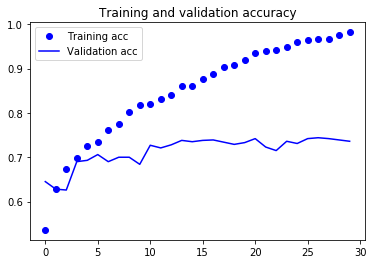

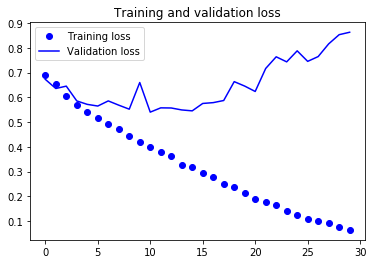

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

These plots are characteristic of overfitting. Our training accuracy increases linearly over time, until it reaches nearly 100%, while our 
validation accuracy stalls at 70-72%. Our validation loss reaches its minimum after only five epochs then stalls, while the training loss 
keeps decreasing linearly until it reaches nearly 0.

Because we only have relatively few training samples (2000), overfitting is going to be our number one concern. You already know about a 
number of techniques that can help mitigate overfitting, such as dropout and weight decay (L2 regularization). We are now going to 
introduce a new one, specific to computer vision, and used almost universally when processing images with deep learning models: *data 
augmentation*.

这些图像中都能看出过拟合的特征。训练精度随着时间线性增加，直到接近 100%，而验证精度则停留在 70%~72%。验证损失仅在 5 轮后就达到最小值，然后保持不变，而训练损失则一直线性下降，直到接近于 0。

因为训练样本相对较少（2000 个），所以过拟合是你最关心的问题。前面已经介绍过几种降低过拟合的技巧，比如 dropout 和权重衰减（L2 正则化）。现在我们将使用一种针对于计算机视觉领域的新方法，在用深度学习模型处理图像时几乎都会用到这种方法，它就是数据增强（data augmentation）。


## Using data augmentation

Overfitting is caused by having too few samples to learn from, rendering us unable to train a model able to generalize to new data. 
Given infinite data, our model would be exposed to every possible aspect of the data distribution at hand: we would never overfit. Data 
augmentation takes the approach of generating more training data from existing training samples, by "augmenting" the samples via a number 
of random transformations that yield believable-looking images. The goal is that at training time, our model would never see the exact same 
picture twice. This helps the model get exposed to more aspects of the data and generalize better.

In Keras, this can be done by configuring a number of random transformations to be performed on the images read by our `ImageDataGenerator` 
instance. Let's get started with an example:
## 使用数据增强

过拟合的原因是学习样本太少，导致无法训练出能够泛化到新数据的模型。如果拥有无限的数据，那么模型能够观察到数据分布的所有内容，这样就永远不会过拟合。数据增强是从现有的训练样本中生成更多的训练数据，其方法是利用多种能够生成可信图像的随机变换来增加（augment）样本。其目标是，模型在训练时不会两次查看完全相同的图像。这让模型能够观察到数据的更多内容，从而具有更好的泛化能力。

在 Keras中，这可以通过对 ImageDataGenerator实例读取的图像执行多次随机变换来实现。我们先来看一个例子。


In [18]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

These are just a few of the options available (for more, see the Keras documentation). Let's quickly go over what we just wrote:

* `rotation_range` is a value in degrees (0-180), a range within which to randomly rotate pictures.
* `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures 
vertically or horizontally.
* `shear_range` is for randomly applying shearing transformations.
* `zoom_range` is for randomly zooming inside pictures.
* `horizontal_flip` is for randomly flipping half of the images horizontally -- relevant when there are no assumptions of horizontal 
asymmetry (e.g. real-world pictures).
* `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

Let's take a look at our augmented images:

这里只选择了几个参数（想了解更多参数，请查阅 Keras 文档）。我们来快速介绍一下这些参数的含义。
*  rotation_range 是角度值（在 0~180 范围内），表示图像随机旋转的角度范围。
*  width_shift 和 height_shift 是图像在水平或垂直方向上平移的范围（相对于总宽度或总高度的比例）。
*  shear_range 是随机错切变换的角度。
*  zoom_range 是图像随机缩放的范围。
*  horizontal_flip 是随机将一半图像水平翻转。如果没有水平不对称的假设（比如真实世界的图像），这种做法是有意义的。
*  fill_mode是用于填充新创建像素的方法，这些新像素可能来自于旋转或宽度 / 高度平移。 

我们来看一下增强后的图像：


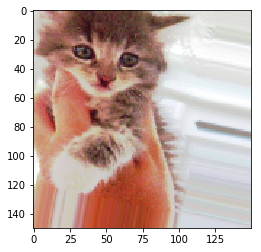

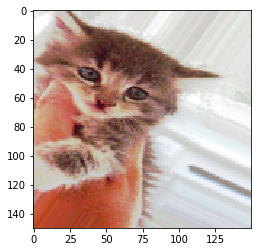

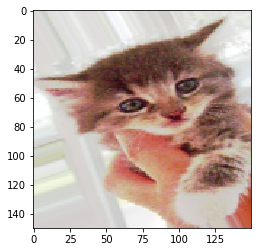

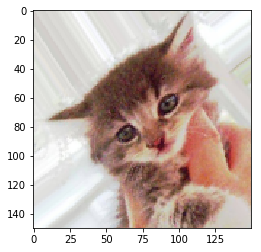

In [19]:
# This is module with image preprocessing utilities（图像预处理工具的模块）
from keras.preprocessing import image

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# We pick one image to "augment"（选择一张图像进行增强）
img_path = fnames[3]

# Read the image and resize it（读取图像并调整大小）
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)（将其转换为形状 (150, 150, 3) 的 Numpy 数组）
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)（将其形状改变为 (1, 150, 150, 3)）
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
#生成随机变换后的图像批量。 循环是无限的，因此你需要在某个时刻终止循环
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

If we train a new network using this data augmentation configuration, our network will never see twice the same input. However, the inputs 
that it sees are still heavily intercorrelated, since they come from a small number of original images -- we cannot produce new information, 
we can only remix existing information. As such, this might not be quite enough to completely get rid of overfitting. To further fight 
overfitting, we will also add a Dropout layer to our model, right before the densely-connected classifier:

In [20]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

Let's train our network using data augmentation and dropout:

我们来训练这个使用了数据增强和 dropout 的网络。

In [21]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!（注意，不能增强验证数据）
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory（目标目录）
        train_dir,
        # All images will be resized to 150x150（将所有图像的大小调整为 150×150）
        target_size=(150, 150),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        #（因为使用了 binary_crossentropy损失，所以需要用二进制标签）
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 33s 335ms/step - loss: 0.6926 - acc: 0.5313 - val_loss: 0.6752 - val_acc: 0.5958
Epoch 2/100
100/100 [==============================] - 29s 290ms/step - loss: 0.6806 - acc: 0.5512 - val_loss: 0.6724 - val_acc: 0.5606
Epoch 3/100
100/100 [==============================] - 32s 317ms/step - loss: 0.6642 - acc: 0.6053 - val_loss: 0.6615 - val_acc: 0.5774
Epoch 4/100
100/100 [==============================] - 32s 317ms/step - loss: 0.6486 - acc: 0.6184 - val_loss: 0.6232 - val_acc: 0.6430
Epoch 5/100
100/100 [==============================] - 32s 316ms/step - loss: 0.6370 - acc: 0.6306 - val_loss: 0.6510 - val_acc: 0.6047
Epoch 6/100
100/100 [==============================] - 33s 328ms/step - loss: 0.6125 - acc: 0.6603 - val_loss: 0.5832 - val_acc: 0.6894
Epoch 7/100
100/100 [==============================] - 32s 323ms/step - loss: 0.6032 - acc: 0.6700 -

100/100 [==============================] - 100s 997ms/step - loss: 0.4189 - acc: 0.8034 - val_loss: 0.4489 - val_acc: 0.7982
Epoch 61/100
100/100 [==============================] - 100s 997ms/step - loss: 0.4033 - acc: 0.8181 - val_loss: 0.4383 - val_acc: 0.8035
Epoch 62/100
100/100 [==============================] - 99s 993ms/step - loss: 0.4065 - acc: 0.8069 - val_loss: 0.4838 - val_acc: 0.7798
Epoch 63/100
100/100 [==============================] - 100s 995ms/step - loss: 0.4011 - acc: 0.8156 - val_loss: 0.4452 - val_acc: 0.8061
Epoch 64/100
100/100 [==============================] - 100s 997ms/step - loss: 0.3866 - acc: 0.8297 - val_loss: 0.4133 - val_acc: 0.8015
Epoch 65/100
100/100 [==============================] - 100s 997ms/step - loss: 0.3943 - acc: 0.8206 - val_loss: 0.4268 - val_acc: 0.7982
Epoch 66/100
100/100 [==============================] - 100s 996ms/step - loss: 0.3796 - acc: 0.8284 - val_loss: 0.4265 - val_acc: 0.8080
Epoch 67/100
100/100 [==========================

Let's save our model -- we will be using it in the section on convnet visualization.
我们把模型保存下来，你会在卷积可视化这节用到它。

In [22]:
model.save('cats_and_dogs_small_2.h5')

Let's plot our results again:
再次画下我们的结果：

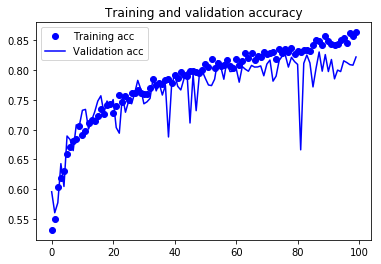

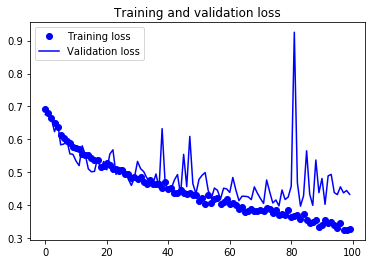

In [23]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Thanks to data augmentation and dropout, we are no longer overfitting: the training curves are rather closely tracking the validation 
curves. We are now able to reach an accuracy of 82%, a 15% relative improvement over the non-regularized model.

By leveraging regularization techniques even further and by tuning the network's parameters (such as the number of filters per convolution 
layer, or the number of layers in the network), we may be able to get an even better accuracy, likely up to 86-87%. However, it would prove 
very difficult to go any higher just by training our own convnet from scratch, simply because we have so little data to work with. As a 
next step to improve our accuracy on this problem, we will have to leverage a pre-trained model, which will be the focus of the next two 
sections.

使用了数据增强和 dropout 之后，模型不再过拟合：训练曲线紧紧跟随着验证曲线。现在的精度为 82%，比未正则化的模型提高了 15%（相对比例）。

通过进一步使用正则化方法以及调节网络参数（比如每个卷积层的过滤器个数或网络中的层数），你可以得到更高的精度，可以达到 86% 到 87%。但只靠从头开始训练自己的卷积神经网络，再想提高精度就十分困难，因为可用的数据太少。想要在这个问题上进一步提高精度，下一步需要使用预训练的模型，这是接下来两节的重点。



